In [193]:
import numpy as np
import pandas as pd

import json

### Loading data

In [298]:
with open('data/machine_learning.json', 'r') as f:
    projects = json.load(f)

In [299]:
len(projects)

863

In [300]:
data = []
for project in projects:
    base = [project['id'], project['title'], project['description'], project['budget']['minimum'],
            project['budget']['maximum'], project['time_submitted']]
    
    project_bids = []
        
    for bid in project['bids']:
        row = [*base]
        
        reputation = bid['reputation']['entire_history']['category_ratings']
        
#         quality": 5.0,
#             "communication": 5.0,
#             "expertise": 5.0,
#             "professionalism": 5.0,
#             "hire_again
        row += [bid['score'], bid['highlighted'], bid['sealed'], bid['description'], bid['time_submitted'], 
                bid['amount'], bid['period'], reputation['quality'], reputation['communication'], 
                reputation['professionalism'], bid['award_status'] == 'awarded']
        
        project_bids.append(row)
        
    if [bid for bid in project_bids if bid[-1]]: # checking if there is awarded bid, if not skip
        data+=project_bids

In [301]:
data_columns = ['project_id', 'project_title', 'project_description', 'project_min_amount',
                'project_max_amount', 'project_time_submitted', 'bid_score', 'bid_highlighted', 'bid_sealed',
                'bid_description', 'bid_time_submitted', 'bid_amount', 'bid_period', 'bid_quality', 
                'bid_communication', 'bid_professionalism', 'bid_award_status']
data = pd.DataFrame(columns=data_columns, data=data)

In [302]:
data.describe()

project_id  project_min_amount  project_max_amount   
count  7.741000e+03         7741.000000         7741.000000  \
mean   3.411203e+07          393.830384         1548.752099   
std    8.892812e+05         2099.633747         6165.852474   
min    3.251029e+07            8.000000           15.000000   
25%    3.341296e+07           10.000000           50.000000   
50%    3.407365e+07           30.000000          250.000000   
75%    3.487830e+07           30.000000          250.000000   
max    3.718741e+07        37500.000000        75000.000000   

       project_time_submitted    bid_score  bid_time_submitted     bid_amount   
count            7.741000e+03  7741.000000        7.741000e+03    7741.000000  \
mean             1.657188e+09     1.152852        1.657200e+09     984.909738   
std              9.267100e+06     6.001925        9.267411e+06    4709.964862   
min              1.640923e+09     0.396905        1.640923e+09       0.000000   
25%              1.649352e+09     0.675041        1.649375e+09      20.000000   
50%              1.657216e+09     0.748068        1.657216e+09     100.000000   
75%              1.665254e+09     0.857398        1.665268e+09     250.000000   
max              1.694663e+09    99.000000        1.694711e+09  150000.000000   

       bid_period  bid_quality  bid_communication  bid_professionalism  
count  7741.00000  7741.000000        7741.000000          7741.000000  
mean      5.41545     4.076194           4.085193             4.080635  
std      12.48506     1.777574           1.779585             1.780145  
min       1.00000     0.000000           0.000000             0.000000  
25%       2.00000     4.522882           4.531604             4.545107  
50%       5.00000     4.908063           4.921666             4.922032  
75%       7.00000     5.000000           5.000000             5.000000  
max     999.00000     5.000000           5.000000             5.000000

In [303]:
sum(abs(data['bid_quality'] - data['bid_communication'])) / len(data)

0.05209223871403339

bid_quality and bid_communication are very similar, but in the same time, each of them have the difference which can have the impact on the final choosen bid

In [304]:
len(data['project_id'].unique()) - sum(data['bid_award_status'])

-27

In [305]:
sum(data.duplicated()), sum(data['project_id'].duplicated())

(0, 7258)

### Looking at boolean properties of bids

In [306]:
print('Bids len:', len(data))
sum(data['bid_award_status']) / len(data) * 100, '%'

Bids len: 7741


(6.588296085777031, '%')

In [307]:
print('Len of highlighted bids:', sum(data['bid_highlighted']))
sum(data.loc[data['bid_highlighted']]['bid_award_status']) / sum(data['bid_highlighted']) * 100, '%'

Len of highlighted bids: 16


(25.0, '%')

In [308]:
print('Len of sealed bids:', sum(data['bid_sealed']))
sum(data.loc[data['bid_sealed']]['bid_award_status']) / sum(data['bid_sealed']) * 100, '%'

Len of sealed bids: 1114


(8.617594254937163, '%')

In [309]:
data = data.drop(['bid_highlighted'], axis=1)

highlighted is negligible because of the a very little amount of such bids compared to all others, while sealed can play a little role

### Adding features

In [310]:
data['project/bid_amount_proportion'] = data['bid_amount'] / data['project_min_amount']
data = data.drop(['bid_amount', 'project_min_amount', 'project_max_amount'], axis=1)

In [311]:
# default bid period = 7days
data['bid_delay'] = (data['bid_time_submitted'] - data['project_time_submitted']) / (3600*24*7) 
data = data.drop(['project_time_submitted', 'bid_time_submitted'], axis=1)

### Transform text data in features

In [312]:
proportions = []

projects_titles_words = data['project_title'].apply(lambda x: x.split() if x else []).apply(set)
bid_descrs_words = data['bid_description'].apply(lambda x: x.split() if x else []).apply(set)

for project_title_set, bid_descr_set in zip(projects_titles_words, bid_descrs_words):
    words_checked = [word in bid_descr_set for word in project_title_set]
    proportions.append(sum(words_checked) / len(words_checked))
    
data['same_words_title/bid_proportion'] = proportions

In [313]:
proportions = []

projects_descrs_words = data['project_description'].apply(lambda x: x.split() if x else []).apply(set)
bid_descrs_words = data['bid_description'].apply(lambda x: x.split() if x else []).apply(set)

for project_descr_set, bid_descr_set in zip(projects_descrs_words, bid_descrs_words):
    words_checked = [word in bid_descr_set for word in project_descr_set]
    proportions.append(sum(words_checked) / len(words_checked))
    
data['same_words_descr/bid_proportion'] = proportions

In [314]:
data['bid_descr_len'] = data['bid_description'].apply(lambda x: len(x.split()) if x else 0)

In [315]:
proj_descr_len = data['project_description'].apply(lambda x: len(x.split()) if x else 0)

In [316]:
data['proj/bid_lens_proportion'] = data['bid_descr_len'] / proj_descr_len

In [317]:
greetings = ['good afternoon', 'good morning', 'how are you', 'how do you do', 'dear sir',
             'good night', 'hi', 'hello', 'pleased to meet you']

data['bid_greetings'] = data['bid_description'].apply(lambda x: x.lower() if x else '').apply(
    lambda x: any([x.find(greeting) != -1  for greeting in greetings]))

In [318]:
len(data) - sum(data['bid_greetings']) # without greeting

1748

### Look at correlations with new added features

In [319]:
data = data.drop(['project_title', 'project_description', 'bid_description'], axis=1)

In [320]:
corr_matrix = data.corr()
corr_matrix["bid_award_status"].abs().sort_values(ascending=False)

bid_award_status                   1.000000
bid_communication                  0.098963
bid_quality                        0.097988
bid_professionalism                0.097589
bid_score                          0.095598
bid_delay                          0.073320
project/bid_amount_proportion      0.054452
bid_greetings                      0.037159
bid_descr_len                      0.035183
bid_sealed                         0.033538
same_words_descr/bid_proportion    0.017861
same_words_title/bid_proportion    0.013983
proj/bid_lens_proportion           0.012081
bid_period                         0.007628
project_id                         0.004849
Name: bid_award_status, dtype: float64

### Adding categorical features

cut function generate bins with equal sizes

In [321]:
data['bin_quality'] = pd.cut(data['bid_quality'], bins=2, 
                             labels=False, include_lowest=True).astype( bool )

In [322]:
data['bid_communication'] = pd.cut(data['bid_communication'], bins=2, 
                             labels=False, include_lowest=True).astype( bool )

In [323]:
data['bid_professionalism'] = pd.cut(data['bid_professionalism'], bins=2, 
                             labels=False, include_lowest=True).astype( bool )

### Looking at linear dependencies

In [324]:
min(data['bid_score']), max(data['bid_score'])

(0.39690506293117, 99.0)

In [325]:
sum(data['bid_score'] > 50.)

29

In [326]:
data = data.drop(np.where(data['bid_score'] > 50.)[0], axis=0).reset_index(drop=True)

In [327]:
import matplotlib.pyplot as plt

def take_proportion_importance(prop_name):

    score_mean = np.mean(data[prop_name])

    big_score = data[prop_name] >= score_mean
    bid_score_percents = sum(data.loc[big_score]['bid_award_status']) / sum(big_score) * 100

    little_score = data[prop_name] < score_mean
    little_score_percents = sum(data.loc[little_score]['bid_award_status']) / sum(little_score) * 100

    print((bid_score_percents, sum(big_score)), (little_score_percents, sum(little_score)))

bid_score also doesn't influence a lot on awardness of the bid

(7.59493670886076, 3002) (5.711252653927813, 4710)


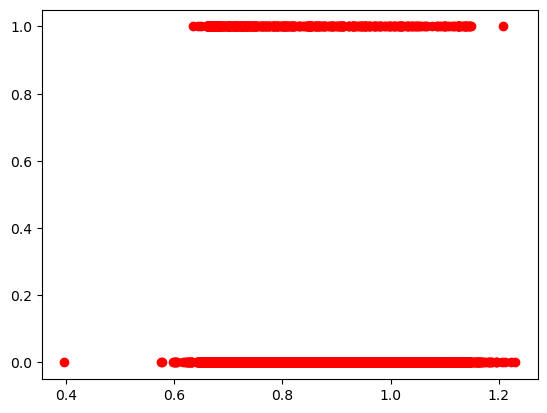

In [328]:
take_proportion_importance('bid_score')
plt.plot(data['bid_score'], data['bid_award_status'], 'ro')

(3.6658442016214314, 2837) (8.061538461538461, 4875)


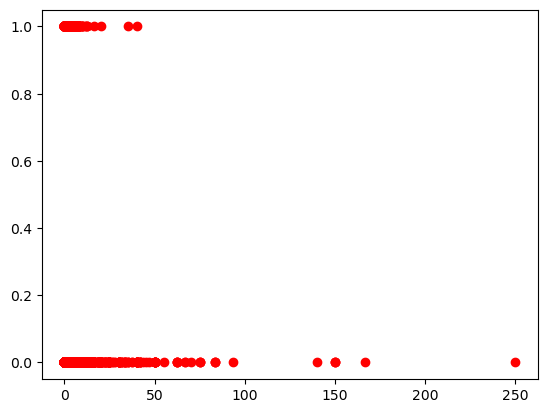

In [329]:
take_proportion_importance('project/bid_amount_proportion')
plt.plot(data['project/bid_amount_proportion'], data['bid_award_status'], 'ro')

In [330]:
take_proportion_importance('bid_delay')

(8.84861407249467, 1876) (5.671692940370116, 5836)


### prepare data

bid_score


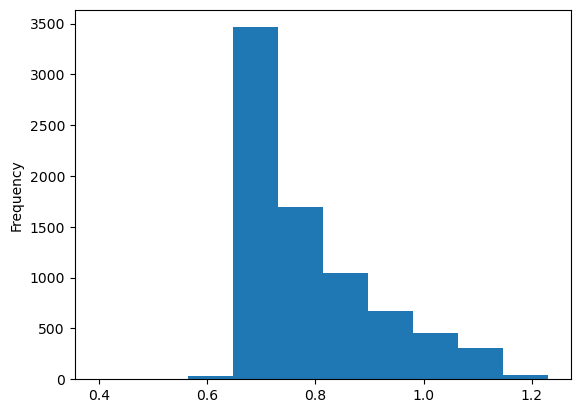

bid_period


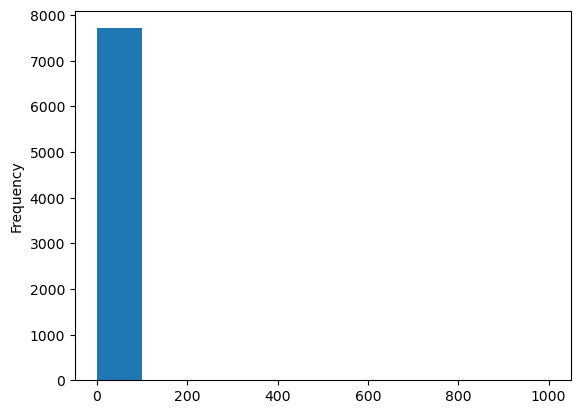

bid_quality


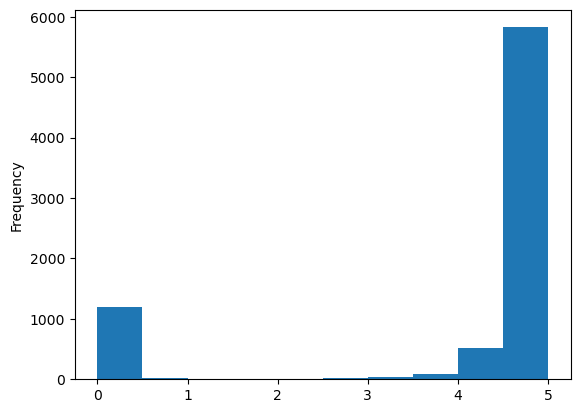

project/bid_amount_proportion


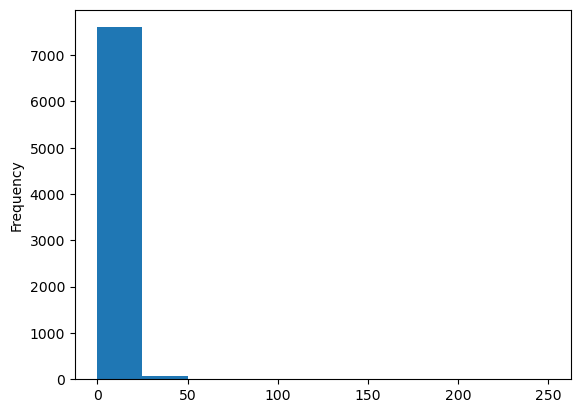

bid_delay


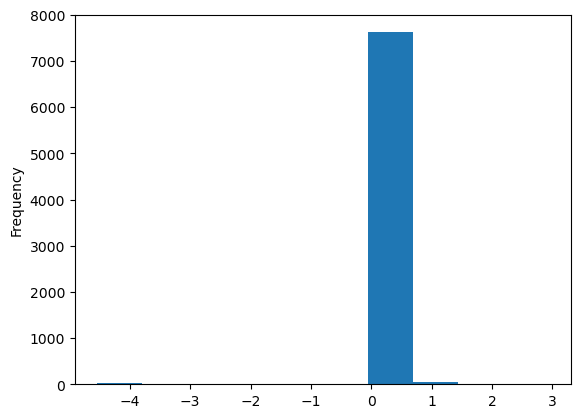

same_words_title/bid_proportion


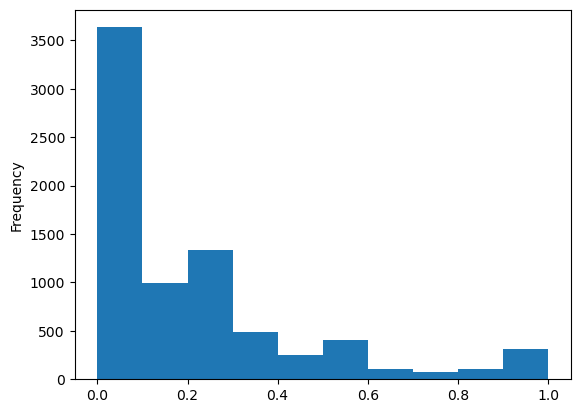

same_words_descr/bid_proportion


bid_descr_len


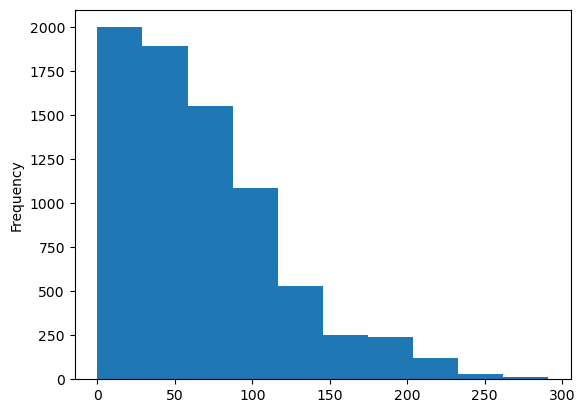

proj/bid_lens_proportion


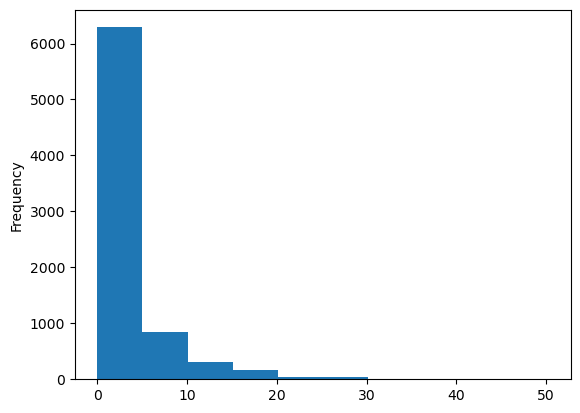

In [331]:
for column in data.select_dtypes(include=['number']).columns:
    if column in ['project_id']: continue
        
#     plt.figure(figsize=(10,2))
    print(column)
    data[column].plot.hist()
    plt.show()

In [332]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=.2)

X = data.drop(['project_id', 'bid_award_status'], axis=1)
project_ids = data['project_id'].values

X_num, X_cat = X.select_dtypes(include=['number']).values, X.select_dtypes(exclude=['number']).values

y = data['bid_award_status'].to_numpy()

for train_index, test_index in sss.split(X,y):
    X_train_num, X_test_num  = X_num[train_index], X_num[test_index]
    X_train_cat, X_test_cat = X_cat[train_index], X_cat[test_index]
    
    y_train, y_test = y[train_index], y[test_index]
    
    project_ids = np.append(project_ids[train_index], project_ids[test_index])

In [333]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

In [334]:
X_train, X_test = np.c_[X_train_num, X_train_cat], np.c_[X_test_num, X_test_cat]

In [335]:
# for train_index, val_index in sss.split(X_train, y_train):
#     X_val, y_val = X_train[val_index], y_train[val_index]
#     X_train, y_train = X_train[train_index], y_train[train_index]

### Algorithms checking

In [336]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score

def get_metrics(y,pred):
    for metric in [accuracy_score, precision_score, recall_score]:
        if metric.__name__ == 'accuracy_score':
            result = metric(y, pred)
        else:
            result = metric(y, pred, zero_division=0)
        print(metric.__name__[:-6], f'{round(result*100,2)}%')


models = [LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, SVC, LinearSVC,
          KNeighborsClassifier, GaussianNB]
for model in models:
    
    print(model.__name__)
    
    try:
        model = model(class_weight='balanced', )
    except:
        model = model()
        
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    
    get_metrics(y_test,pred)
        
    print()

LogisticRegression
accuracy 49.97%
precision 9.21%
recall 76.77%

RandomForestClassifier
accuracy 93.58%
precision 50.0%
recall 1.01%

GradientBoostingClassifier
accuracy 93.71%
precision 75.0%
recall 3.03%

SVC
accuracy 55.61%
precision 9.97%
recall 73.74%

LinearSVC


/home/hacker/_sources/_apps/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy 48.35%
precision 9.13%
recall 78.79%

KNeighborsClassifier
accuracy 93.52%
precision 45.45%
recall 5.05%

GaussianNB
accuracy 29.16%
precision 7.67%
recall 90.91%



### Further training of one of the best models (SVC - Support Vector Classification)

In [337]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

svc = SVC(class_weight='balanced')

params_distributions = {"gamma": reciprocal(.0001, 0.5), "C": uniform(1,15)}
rnd_search_cv = RandomizedSearchCV(svc, params_distributions, n_iter=10, verbose=2, cv=3, scoring='f1')
rnd_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....C=2.9795712456729833, gamma=0.0022469075884805; total time=   1.6s
[CV] END .....C=2.9795712456729833, gamma=0.0022469075884805; total time=   1.6s
[CV] END .....C=2.9795712456729833, gamma=0.0022469075884805; total time=   1.6s
[CV] END ....C=12.513403566980532, gamma=0.02955194223498697; total time=   1.5s
[CV] END ....C=12.513403566980532, gamma=0.02955194223498697; total time=   1.5s
[CV] END ....C=12.513403566980532, gamma=0.02955194223498697; total time=   1.5s
[CV] END ...C=3.524400448502831, gamma=0.0002197222920863366; total time=   1.9s
[CV] END ...C=3.524400448502831, gamma=0.0002197222920863366; total time=   1.9s
[CV] END ...C=3.524400448502831, gamma=0.0002197222920863366; total time=   1.8s
[CV] END ...C=10.761106844109145, gamma=0.011009214500460713; total time=   1.5s
[CV] END ...C=10.761106844109145, gamma=0.011009214500460713; total time=   1.8s
[CV] END ...C=10.761106844109145, gamma=0.011009

RandomizedSearchCV(cv=3, estimator=SVC(class_weight='balanced'),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fe6ec333790>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fe6d3099af0>},
                   scoring='f1', verbose=2)

In [338]:
round(rnd_search_cv.best_score_*100,2)

18.34

In [339]:
best_estimator = rnd_search_cv.best_estimator_
best_estimator

SVC(C=7.3308049907478745, class_weight='balanced', gamma=0.045798151396616624)

In [340]:
pred = best_estimator.predict(X_test)
get_metrics(y_test,pred)

accuracy 56.58%
precision 9.96%
recall 71.72%


### Further training RandomForests

In [341]:
from sklearn.model_selection import GridSearchCV

svc = RandomForestClassifier(class_weight='balanced')

params_grid = [{"n_estimators": [5,20,100], "max_features": [2,4]},
               {"min_samples_leaf": [2,4], "max_depth": [2,3]}]

grid_search_cv = RandomizedSearchCV(svc, params_grid, n_iter=10, verbose=2, cv=3, scoring='recall')
grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....................max_features=2, n_estimators=5; total time=   0.1s
[CV] END .....................max_features=2, n_estimators=5; total time=   0.1s
[CV] END .....................max_features=2, n_estimators=5; total time=   0.1s
[CV] END ....................max_features=2, n_estimators=20; total time=   0.2s
[CV] END ....................max_features=2, n_estimators=20; total time=   0.2s
[CV] END ....................max_features=2, n_estimators=20; total time=   0.2s
[CV] END ...................max_features=2, n_estimators=100; total time=   0.8s
[CV] END ...................max_features=2, n_estimators=100; total time=   0.8s
[CV] END ...................max_features=2, n_estimators=100; total time=   0.8s
[CV] END .....................max_features=4, n_estimators=5; total time=   0.1s
[CV] END .....................max_features=4, n_estimators=5; total time=   0.1s
[CV] END .....................max_features=4, n_

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   param_distributions=[{'max_features': [2, 4],
                                         'n_estimators': [5, 20, 100]},
                                        {'max_depth': [2, 3],
                                         'min_samples_leaf': [2, 4]}],
                   scoring='recall', verbose=2)

In [342]:
best_estimator = grid_search_cv.best_estimator_
best_estimator

RandomForestClassifier(class_weight='balanced', max_depth=2, min_samples_leaf=2)

In [343]:
pred = best_estimator.predict(X_test)
get_metrics(y_test,pred)

accuracy 44.98%
precision 8.88%
recall 81.82%


### Dense Neural Network

#### create dataset

In [344]:
len(data), len(project_ids)

(7712, 7712)

In [345]:
X = np.append(X_train, X_test, axis=0)
y = np.append(y_train, y_test, axis=0)

X.shape, X_train.shape

((7712, 14), (6169, 14))

In [362]:
bids_per_project = 10

projects_with_filtered_bids = []
y_bids = []

for project_id in set(project_ids):
    bids_x = X[project_ids == project_id]
    bids_y = y[project_ids == project_id]
    
    if len(bids_x) < bids_per_project: continue
    
    filtered_bids = bids_x[bids_y]
    pred = best_estimator.predict_proba(bids_x[~bids_y])[:, 1]
    
    to_add = bids_per_project - len(filtered_bids)
    
    order = np.argsort(pred)[:-to_add-1:-1]
    
    bids = np.append(filtered_bids, bids_x[order], axis=0)
    
    projects_with_filtered_bids.append(bids)
    y_bids += [True, *[False] * (bids_per_project-1)]
    
filtered_bids = [bid for bids in projects_with_filtered_bids for bid in bids]

In [286]:
import tensorflow as tf
from tensorflow import keras

2023-11-29 06:16:41.187153: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 06:16:41.879171: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 06:16:44.347104: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [363]:
len(filtered_bids), len(y_bids)

(4810, 4810)

In [402]:
sample_weights = np.array(y_bids) * 9 + 1

In [403]:
ds = tf.data.Dataset.from_tensor_slices((filtered_bids, y_bids, sample_weights))

In [404]:
ds = ds.batch(3 * bids_per_project)

In [405]:
train_size = int(len(ds) *.8)

train_ds = ds.take(train_size)
test_ds = ds.skip(train_size)

val_size = int(len(train_ds) *.2)
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size).shuffle(buffer_size=1000).prefetch(1)

#### create network

In [406]:
from functools import partial

get_layer = partial(keras.layers.Dense, activation='selu', kernel_initializer='lecun_normal')
model = keras.models.Sequential([
    get_layer(X.shape[1]),
    get_layer(5),
    keras.layers.Dense(1, activation='sigmoid')
])

In [412]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()],
              weighted_metrics=[])

In [415]:
callbacks = []

early_stop = keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
callbacks.append(early_stop)

learning_rate_scheduler = keras.callbacks.ReduceLROnPlateau(patience=5, factor=.7)
callbacks.append(early_stop)

hist = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
103/103 [==============================] - 0s 4ms/step - loss: 1.1673 - accuracy: 0.5650 - precision_3: 0.1584 - recall_3: 0.7767 - val_loss: 1.2813 - val_accuracy: 0.5720 - val_precision_3: 0.1382 - val_recall_3: 0.6267
Epoch 2/50
103/103 [==============================] - 0s 4ms/step - loss: 1.1667 - accuracy: 0.5722 - precision_3: 0.1603 - recall_3: 0.7735 - val_loss: 1.2834 - val_accuracy: 0.5787 - val_precision_3: 0.1381 - val_recall_3: 0.6133
Epoch 3/50
103/103 [==============================] - 0s 4ms/step - loss: 1.1675 - accuracy: 0.5825 - precision_3: 0.1615 - recall_3: 0.7573 - val_loss: 1.2808 - val_accuracy: 0.4947 - val_precision_3: 0.1364 - val_recall_3: 0.7600
Epoch 4/50
103/103 [==============================] - 0s 4ms/step - loss: 1.1677 - accuracy: 0.5599 - precision_3: 0.1572 - recall_3: 0.7799 - val_loss: 1.2846 - val_accuracy: 0.5453 - val_precision_3: 0.1306 - val_recall_3: 0.6267
Epoch 5/50
103/103 [==============================] - 0s 4ms/step - loss

In [416]:
metrics = model.evaluate(test_ds)
print(f'Accuracy: {metrics[1]*100}%, precision: {metrics[2]*100}%, recall: {metrics[3]*100}%')

33/33 [==============================] - 0s 3ms/step - loss: 1.2347 - accuracy: 0.5856 - precision_3: 0.1429 - recall_3: 0.6289
Accuracy: 58.55669975280762%, precision: 14.28571492433548%, recall: 62.886595726013184%
